#### Рудзянский Артемий БИБ201
# Домашнее задание 3

In [1]:
import numpy as np
import pandas as pd
import sklearn

In [2]:
# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Задание 1: EM-алгоритм

**Открыть датасет sklearn.datasets.load_wine, содержащий информацию о трех различных сортах вина (class0, class1, class2). Ответить
на вопросы ниже, используя средства языка Python и необходимых
библиотек**

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
data = load_wine()
data.target[[10, 80, 140]]
list(data.target_names)

['class_0', 'class_1', 'class_2']

Преобразование данных из sklearn в pandas датасет

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Анализ содержания

In [5]:
display(df['target'].unique(), df.shape)

array([0, 1, 2])

(178, 14)

По итогу имеем три класса и 13 признаков.
Датасет иммет 178 объектов (маловато).

Выведем названия всех признаков

In [6]:
def x_y(dataframe): 
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values
    return X, y

display(*list(df))

'alcohol'

'malic_acid'

'ash'

'alcalinity_of_ash'

'magnesium'

'total_phenols'

'flavanoids'

'nonflavanoid_phenols'

'proanthocyanins'

'color_intensity'

'hue'

'od280/od315_of_diluted_wines'

'proline'

'target'

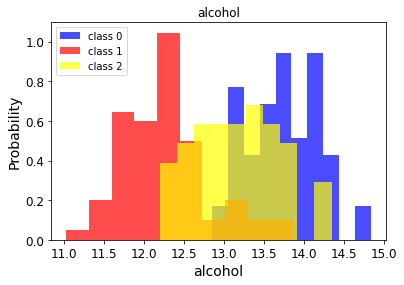

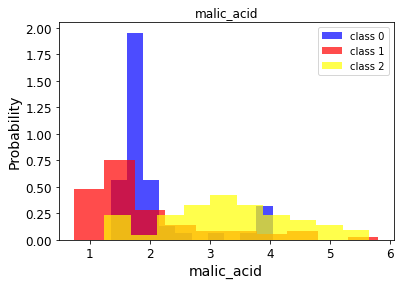

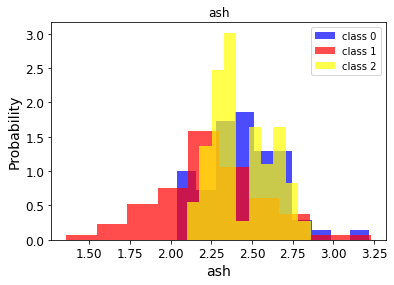

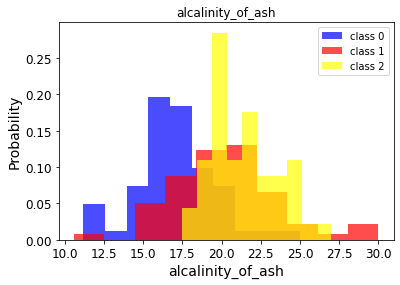

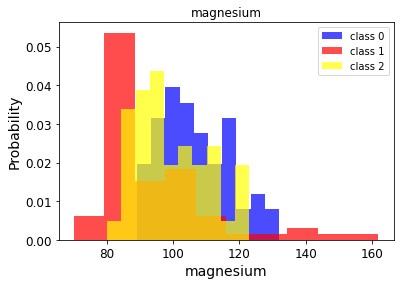

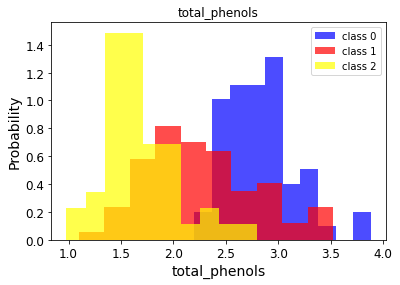

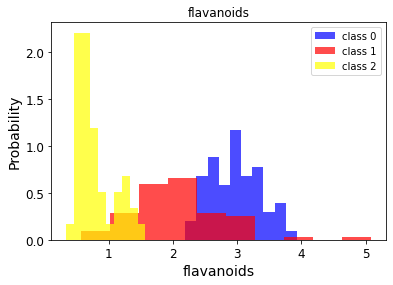

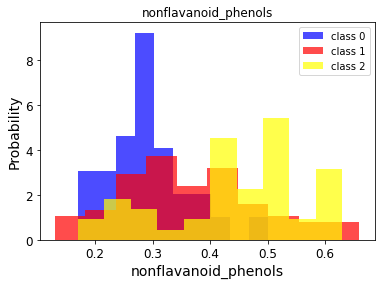

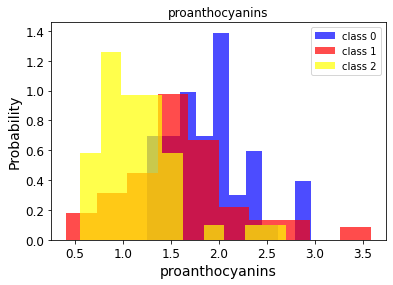

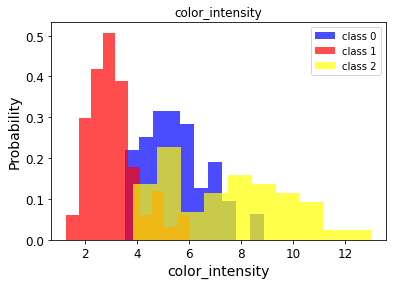

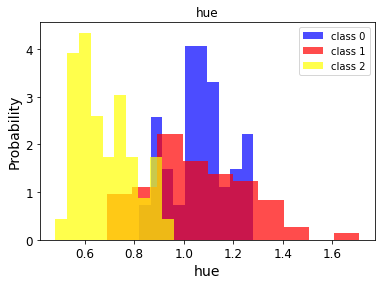

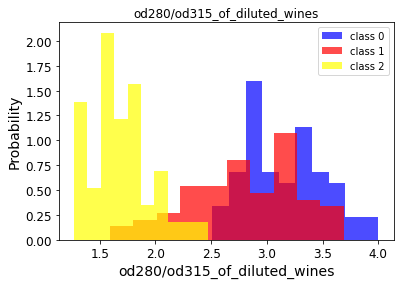

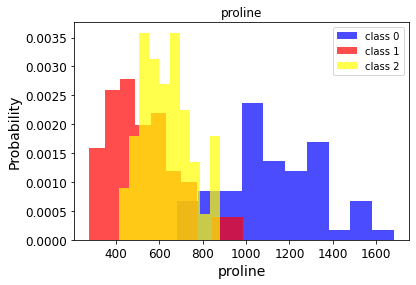

In [7]:
for label in df.columns[:-1]:
    plt.hist(df[df["target"]==0][label], color='blue', label='class 0', alpha=0.7, density=True)
    plt.hist(df[df["target"]==1][label], color='red', label='class 1', alpha=0.7, density=True)
    plt.hist(df[df["target"]==2][label], color='yellow', label='class 2', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

Выбираем *malic_acid* и *proline*

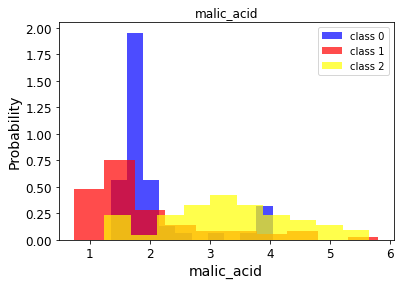

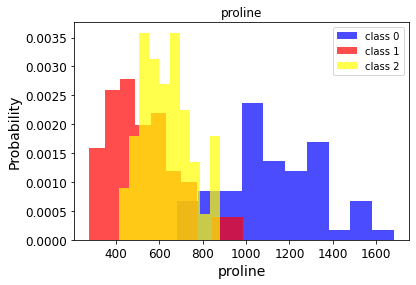

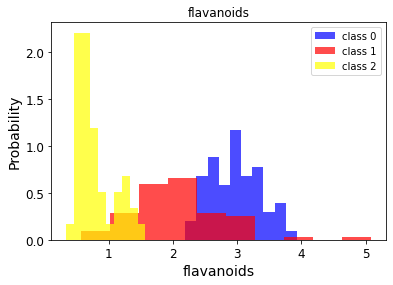

In [8]:
df = df[["malic_acid", "proline", "flavanoids", "target"]]
for label in df.columns[:-1]:
    plt.hist(df[df["target"]==0][label], color='blue', label='class 0', alpha=0.7, density=True)
    plt.hist(df[df["target"]==1][label], color='red', label='class 1', alpha=0.7, density=True)
    plt.hist(df[df["target"]==2][label], color='yellow', label='class 2', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

In [9]:
display(df.head(), df.shape)


,malic_acid,proline,flavanoids,target
0,1.71,1065.0,3.06,0
1,1.78,1050.0,2.76,0
2,2.36,1185.0,3.24,0
3,1.95,1480.0,3.49,0
4,2.59,735.0,2.69,0


(178, 4)

In [10]:
import math

def e_step(x, k, m, n, w, mu, sigma):
    # инициализируем массив плотностей вероятностей извлечения i-ой детали из произведенных на j-м станке 
    pj_xi = []
    for j in range(k):
        det_sigma_j = np.linalg.det(sigma[j])
        factor_1 = 1 / (((2 * math.pi)**(k/2)) * ((det_sigma_j)**0.5))
        factor_2 = []
        for i in x:
            factor_2.append(math.e**float(
                -0.5 * np.matrix(i - mu[j]) * np.matrix(np.linalg.inv(sigma[j])) * np.matrix(i - mu[j]).T))
        pj_xi.append(factor_1 * np.array(factor_2))
    pj_xi = np.array(pj_xi)
    
    # инициализируем массив плотностей вероятностей того, что i-я деталь произведена на j-м станке
    pj_xi_w = []
    for j in range(k):
        pj_xi_w.append(pj_xi[j] * w[j])
    pj_xi_w = np.array(pj_xi_w)
    
    # рассчитаем плотность вероятности извлечения i-й детали среди всех деталей  
    sum_pj_xi_w = np.sum(pj_xi_w, axis = 0)
    
    # инициализируем массив вероятностей отнесения каждой детали к каждому станку
    proba_xi = []
    for j in range(k):
        proba_xi.append(pj_xi_w[j] / sum_pj_xi_w)
    
    return np.array(proba_xi)

    

def m_step(x, proba_xi,N):
    w_new = np.sum(proba_xi, axis = 1) / N
    
    # рассчитаем математическое ожидание
    mu_new = (np.array((np.matrix(proba_xi) * np.matrix(X))).T / np.sum(proba_xi, axis = 1)).T
    
    # рассчитаем дисперсии
    cov_new = []
    for mu in range(mu_new.shape[0]):
        X_cd = []
        X_cd_proba = []
        count = 0
        for x_i in x:
            cd = np.array(x_i - mu_new[mu])
            X_cd.append(cd)
            X_cd_proba.append(cd * proba_xi[mu][count])
            count += 1
        X_cd = np.array(X_cd)
        X_cd = X_cd.reshape(N, m)
        X_cd_proba = np.array(X_cd_proba)
        X_cd_proba = X_cd_proba.reshape(N, m)

        cov_new.append(np.matrix(X_cd.T) * np.matrix(X_cd_proba))
    cov_new = np.array((np.array(cov_new) / (np.sum(proba_xi, axis = 1)-1)))
    # при расчете матрицы ковариации в некоторых случаях могут быть элементы с отрицательными значениями, переведем их в нули
    # на основной рассчет такой перевод не повлияет, но упростит извлечение корня из значений матрицы ковариации
    if cov_new[0][0][1] < 0:
        cov_new[0][0][1] = 0
    if cov_new[0][1][0] < 0:
        cov_new[0][1][0] = 0
    
    if cov_new[1][0][1] < 0:
        cov_new[1][0][1] = 0
    if cov_new[1][1][0] < 0:
        cov_new[1][1][0] = 0
    
    # рассчитаем стандартное отклонение
    sigma_new = cov_new**0.5
    return w_new, mu_new, sigma_new

    
# запишем функцию, в соответствии с которой, на основании данных о вероятности отнесения изделия к тому или иному станку,
# будет определятся на каком станке изделие производилось
def x_new(proba_xi):
    X1_new_ind = []
    X2_new_ind = []
    X_answers = []

    count = 0
    for x in proba_xi[0]:
        if x >= 0.5:
            X1_new_ind.append(count)
            X_answers.append(1)
        else:
            X2_new_ind.append(count)
            X_answers.append(2)
        count += 1
    # на выходе получаем вектор индексов изделий, произведенных на станке №1, №2 и вектор ответов
    return X1_new_ind, X2_new_ind, X_answers

In [11]:
#mean_1, std_1 = np.mean(df["malic_acid"]), np.std(df["malic_acid"])
#mean_2, std_2 = np.mean(df["proline"]), np.std(df["proline"])
k = len(df["target"].unique()) # число классов

#print(mean_1, std_1)
#print(mean_2, std_2)

X, y = x_y(df)
m = df.shape[1] - 1
n = df.shape[0]

class_0 = df[df["target"] == 0]
class_1 = df[df["target"] == 1]
class_2 = df[df["target"] == 2]

# среднее значение malic_acid для первого класса
mean_samples_1_1 = np.mean(class_0["malic_acid"])
# среднее значение malic_acid для второго класса
mean_samples_1_2 = np.mean(class_1["malic_acid"])
# среднее значение malic_acid для третьего класса
mean_samples_1_3 = np.mean(class_2["malic_acid"]) 
# среднее значение proline для первого класса
mean_samples_2_1 = np.mean(class_0["proline"]) 
# среднее значение proline ля второго класса
mean_samples_2_2 = np.mean(class_1["proline"])
# среднее значение proline для третьего класса
mean_samples_2_3 = np.mean(class_2["proline"])
# среднее значение flavanoids для первого класса
mean_samples_3_1 = np.mean(class_0["flavanoids"]) 
# среднее значение flavanoids для второго класса
mean_samples_3_2 = np.mean(class_1["flavanoids"])
# среднее значение flavanoids для третьего класса
mean_samples_3_3 = np.mean(class_2["flavanoids"])

# std malic_acid for class 0
std_samples_1_1 = class_0["malic_acid"].std()
# std malic_acid for class 1
std_samples_1_2 = class_1["malic_acid"].std()
# std malic_acid for class 2
std_samples_1_3 = class_2["malic_acid"].std()
# std proline for class 0
std_samples_2_1 = class_0["proline"].std()
# std proline for class 1
std_samples_2_2 = class_1["proline"].std()
# std proline for class 2
std_samples_2_3 = class_2["proline"].std()
# std flavanoids for class 0
std_samples_3_1 = class_0["flavanoids"].std()
# std flavanoids for class 1
std_samples_3_2 = class_1["flavanoids"].std()
# std flavanoids for class 2
std_samples_3_3 = class_2["flavanoids"].std()


# инициализируем априорную вероятность извлечь изделие, произведенное на станке №1 и №2
w = np.array([float(1./k), float(1./k), float(1./k)])
# w = np.array([ sum(df["target"] == 0) / n, sum(df["target"] == 1) / n, sum(df["target"] == 2) / n ])
mu = np.array([
    [mean_samples_1_1, mean_samples_1_2, mean_samples_1_3],
    [mean_samples_2_1, mean_samples_2_2, mean_samples_2_3],
    [mean_samples_3_1, mean_samples_3_2, mean_samples_3_3]
    ])
sigma = np.array([
    [std_samples_1_1, 0., 0.], [0., std_samples_1_2, 0.], [0., 0., std_samples_1_3],
    [std_samples_2_1, 0., 0.], [0., std_samples_2_2, 0.], [0., 0., std_samples_2_3],
    [std_samples_3_1, 0., 0.], [0., std_samples_3_2, 0.], [0., 0., std_samples_3_3]
                  ])
#print(mu)
sigma = sigma.reshape(m, k, k)

In [12]:
print(k, m)

3 3


FullEM()

/tmp/ipykernel_17387/1745075421.py:28: RuntimeWarning: invalid value encountered in true_divide
  proba_xi.append(pj_xi_w[j] / sum_pj_xi_w)


Итерация № 1
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


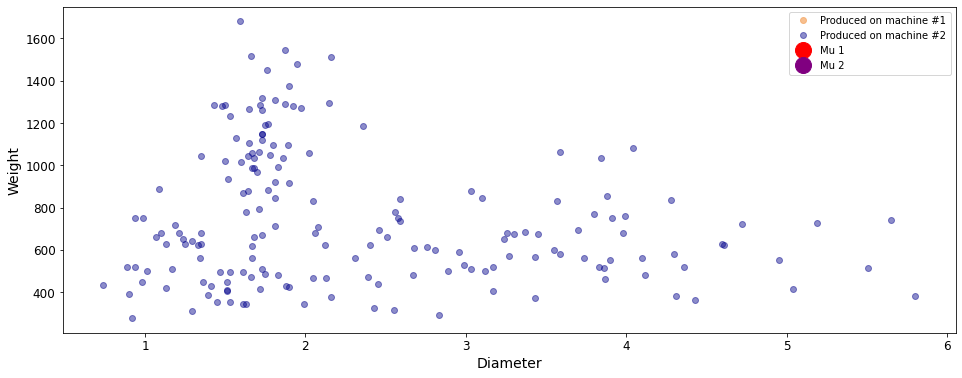

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 2
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


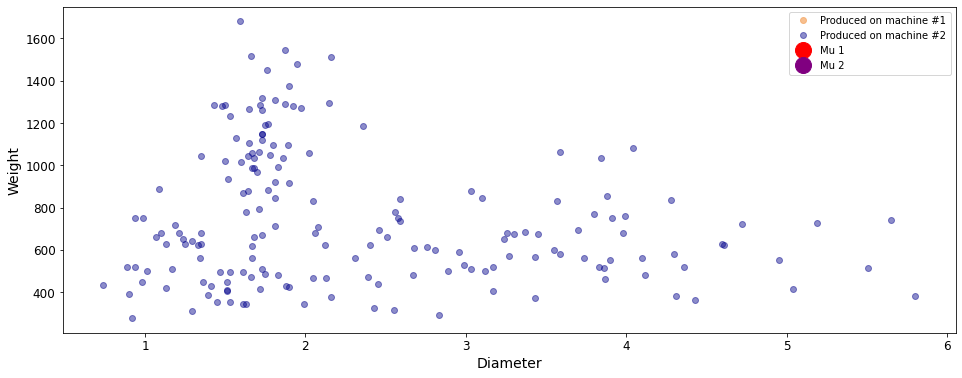

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 3
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


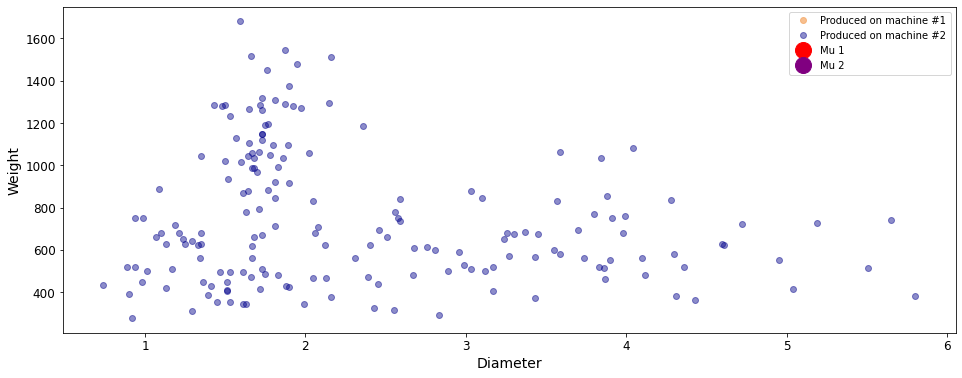

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 4
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


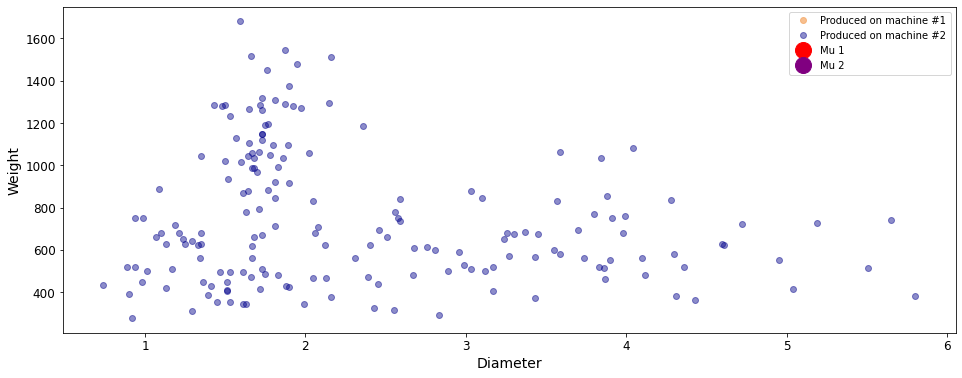

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 5
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


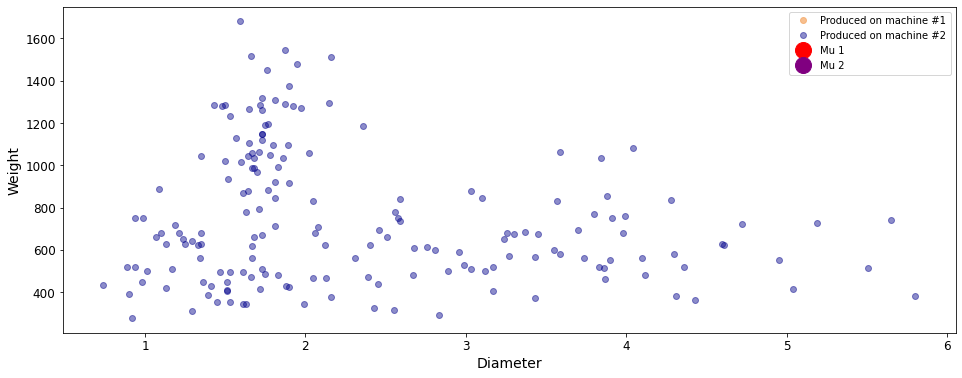

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 6
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


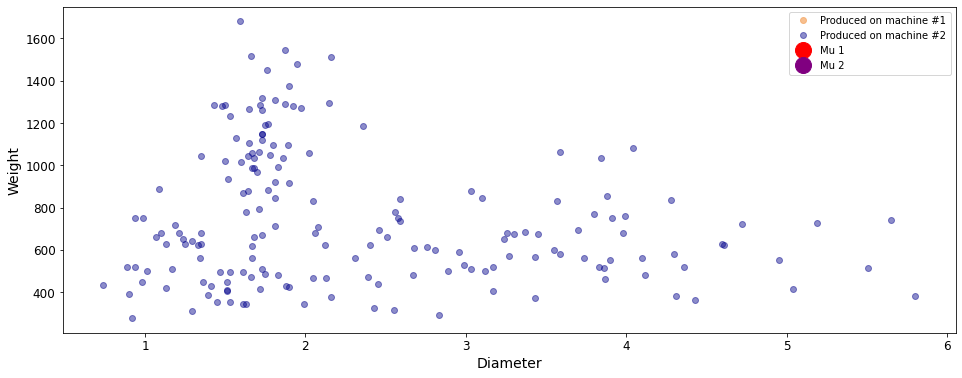

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 7
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


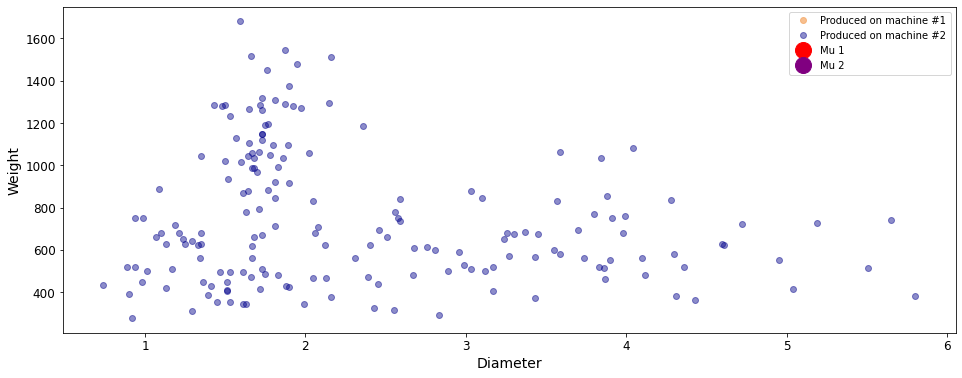

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 8
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


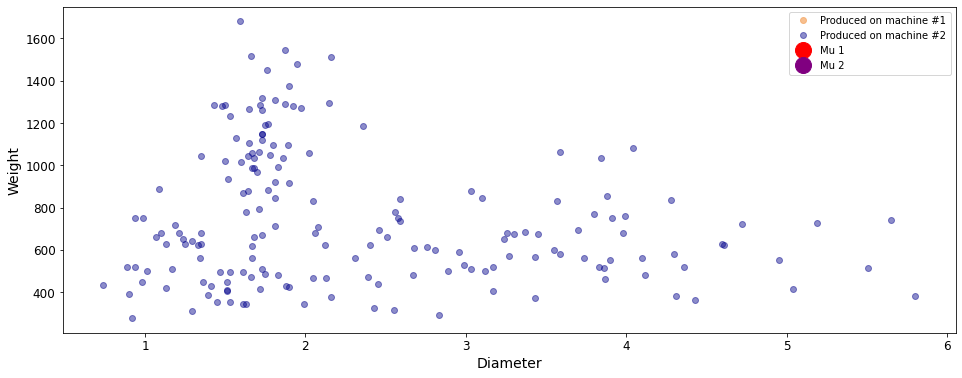

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 9
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


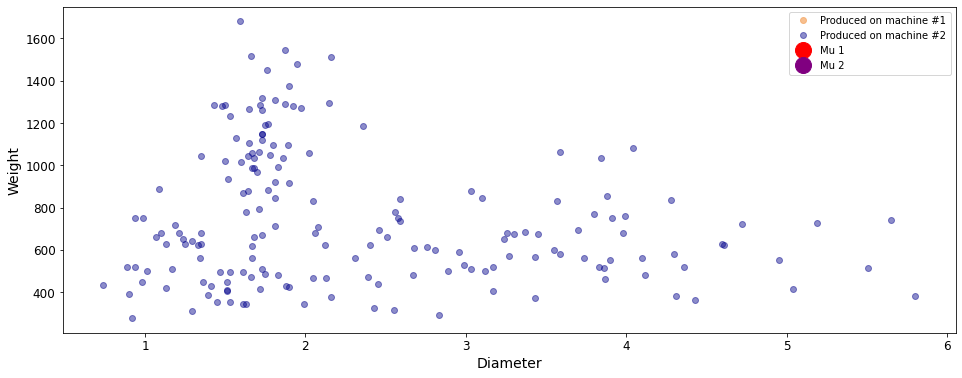

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 10
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


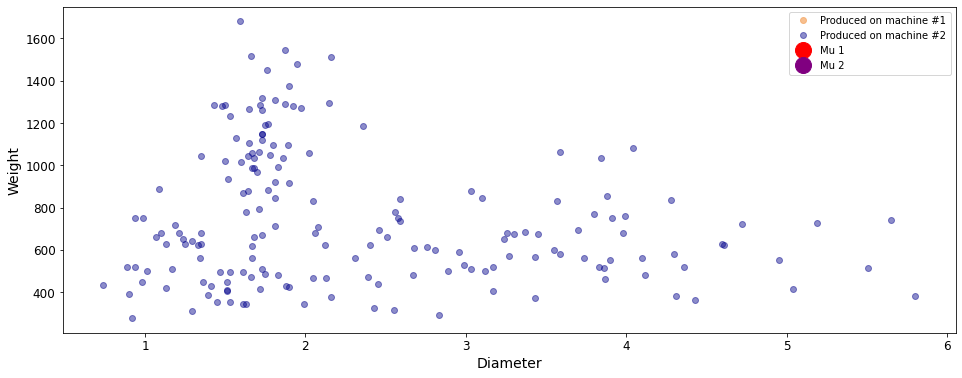

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 11
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


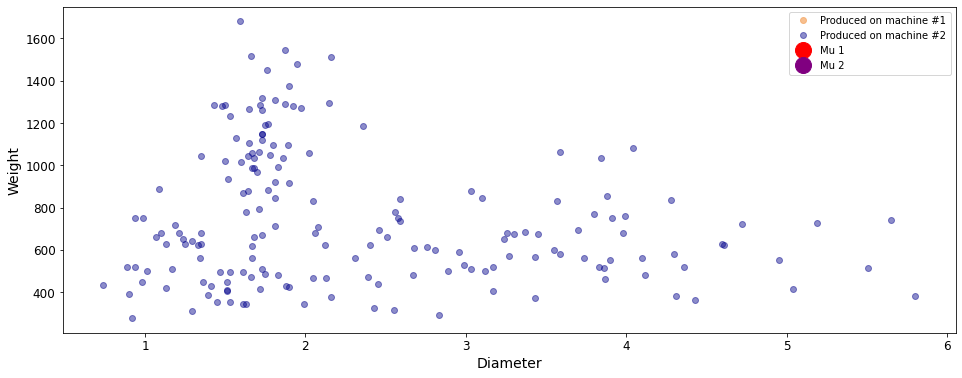

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 12
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


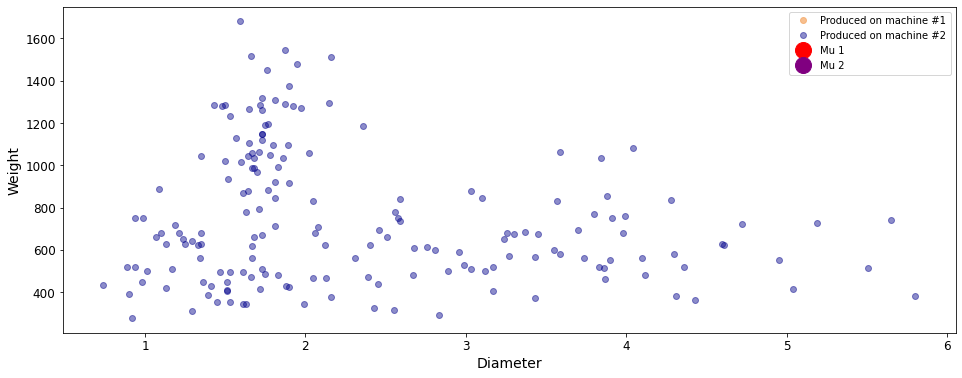

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 13
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


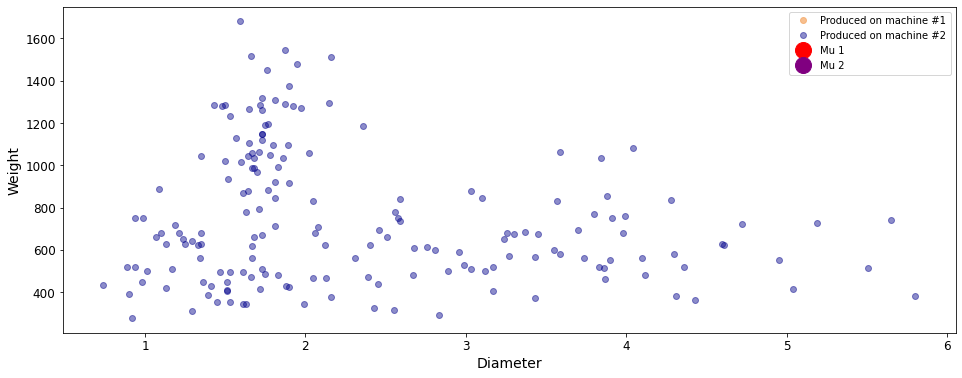

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 14
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


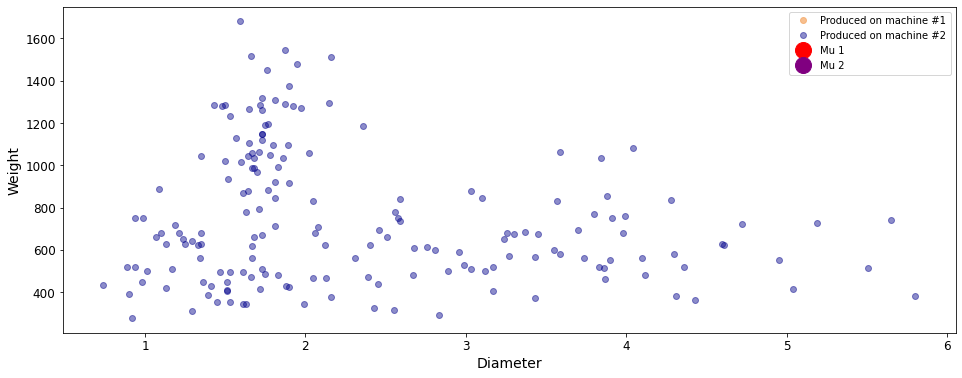

/home/echo/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Итерация № 15
Матрица значений математических ожиданий
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Матрица значений стандартных отклонений
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
Доля правильно распознанных изделий
0.27


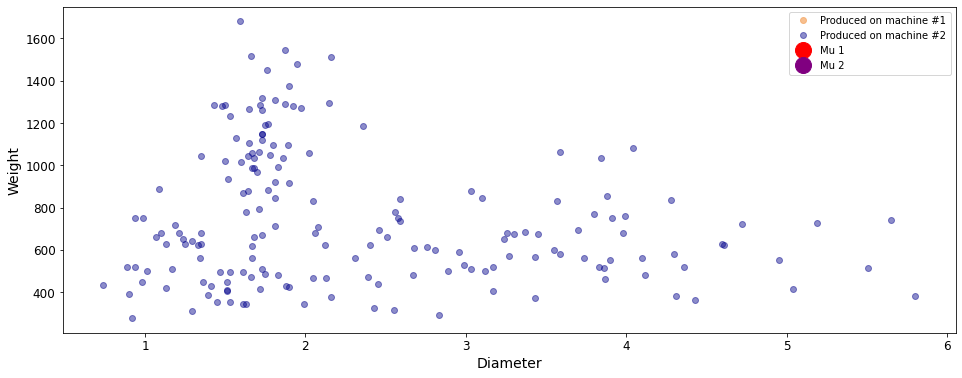

In [13]:
def step_plot():
    print('Итерация №', i+1)
    print('Матрица значений математических ожиданий')
    print(mu)
    print('Матрица значений стандартных отклонений')
    print(sigma)
    print('Доля правильно распознанных изделий')
    print(round(accuracy_score(y, X_answers),3))
    
    plt.figure(figsize=(16, 6))  
    plt.plot(
        X[X1_new_ind,0], X[X1_new_ind,1], 'o', alpha = 0.7, color='sandybrown', label = 'Produced on machine #1')
    plt.plot(
        X[X2_new_ind,0], X[X2_new_ind,1], 'o', alpha = 0.45, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'purple', label = 'Mu 2')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

epsilon = 1
steps = 15
for i in range(steps):
    proba_xi = e_step(X, k, m, n, w, mu, sigma)
    w, mu, sigma = m_step(X, proba_xi, n)
    X1_new_ind, X2_new_ind, X_answers = x_new(proba_xi)
    print('Итерация №', i+1)
    print('Матрица значений математических ожиданий')
    print(mu)
    print('Матрица значений стандартных отклонений')
    print(sigma)
    print('Доля правильно распознанных изделий')
    print(round(accuracy_score(y, X_answers),3))
    
    plt.figure(figsize=(16, 6))  
    plt.plot(
        X[X1_new_ind,0], X[X1_new_ind,1], 'o', alpha = 0.7, color='sandybrown', label = 'Produced on machine #1')
    plt.plot(
        X[X2_new_ind,0], X[X2_new_ind,1], 'o', alpha = 0.45, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'purple', label = 'Mu 2')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

#while epsilon > 0.02:
#    proba_xi = e_step(X, ) 
#    w, mu, sigma = m_step(X, proba_xi, N)
#    X1_new_
#    
#    step_plot()
   

**Используя файл *Sem5_EM.ipynb*, модифицировать алгоритм EM
так, чтобы он умел распознавать три класса (в исходной реализации
умеем делать только бинарную классификацию)**

# Задание 2: kNN

kNN - k-Nearest Neighbors
k ближайших соседей. Алгоритм классификации. Для каждого из объектов мы определяем 

In [ ]:
import numpy as np
import pandas as pd

# stable output across runs
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target
data.target_names

In [ ]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
df.head()

## Train, validation, test datasets

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

[RandomOverSampler](https://imbalanced-learn.org/stable/over_sampling.html)

In [ ]:
def x_y(dataframe): 
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values
    return X, y

def scale_dataset(X,y, oversample=False):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if oversample:
        ros = RandomOverSampler() # добавляем новые объекты для того, чтобы уравнять наборы классов (генерируем их случайным образом)
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42) # split data
X_train, y_train = x_y(train) # get train features and labels
X_test, y_test = x_y(test)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
y_test == y_pred

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

# <font color='yellow'>
### Stratified K-Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score

def skf_cv(X_train, y_train, k):
    sum_accuracy = 0
    skfolds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in skfolds.split(X_train, y_train):
        clone_model = clone(knn_model)
        X_train_folds = X_train[train_index] # набор для обучения
        y_train_folds = y_train[train_index] # реальные метки для обучения
        X_test_fold = X_train[test_index] # набор для валидации (промежуточного тестирования)
        y_test_fold = y_train[test_index] # реальные метки
    
        clone_model.fit(X_train_folds, y_train_folds) # обучение
        y_pred = clone_model.predict(X_test_fold) # обработка validation set (dev-set)
        acc = accuracy_score(y_test_fold, y_pred)
        # print("Accuracy: {0:.2f}".format(acc))
        sum_accuracy += acc 
    return sum_accuracy / k, k
    
    # print("Mean Accuracy: {0:.2f}".format(sum_accuracy / k))

# <font color='yellow'>
### K-Fold

In [ ]:
from sklearn.model_selection import KFold

def kf_cv(X_train, y_train, k):
    sum_accuracy = 0
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train, y_train):
        clone_model = clone(knn_model)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
    
        clone_model.fit(X_train_folds, y_train_folds) # training
        y_pred = clone_model.predict(X_test_fold) # validation
        acc = accuracy_score(y_test_fold, y_pred)
        # print("Accuracy: {0:.2f}".format(acc))
        sum_accuracy += acc 
    return sum_accuracy / k, k
    
    print("Mean Accuracy: {0:.2f}".format(sum_accuracy / k))

# <font color='yellow'>
### LOO

In [ ]:
from sklearn.model_selection import LeaveOneOut

def loo_cv(X_train, y_train):
    loo = LeaveOneOut()
    sum_accuracy = 0
    for train_index, test_index in loo.split(X_train, y_train):
        clone_model = clone(knn_model)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
    
        clone_model.fit(X_train_folds, y_train_folds) # training
        y_pred = clone_model.predict(X_test_fold) # validation
        acc = accuracy_score(y_test_fold, y_pred)
       # print("Accuracy: {0:.2f}".format(acc))
        sum_accuracy += acc
    return sum_accuracy / len(X_train)    

    #print("Mean Accuracy: {0:.2f}".format(sum_accuracy / len(X_train)))

#### Find the best cv algorithm and the best $k$

In [ ]:
print(len(y_train))
best_k = (0, 0)
for k in range(2, 50):
    current_k = kf_cv(X_train, y_train, k)
    if current_k[0] > best_k[0]:
        best_k = current_k 
print("K-Fold", best_k)

best_k = (0, 0)
for k in range(2, 50):
    try:
        current_k = skf_cv(X_train, y_train, k)
        if current_k[0] > best_k[0]:
            best_k = current_k 
    except ValueError:
        break
print("Stratified K-Fold", best_k)

print("LeaveOneOut", loo_cv(X_train, y_train))



Scale then validate again

In [ ]:
train, X_train, y_train = scale_dataset(X_train, y_train, oversample=True)
print( len(y_train), sum(y_train == 0), sum(y_train == 1), sum(y_train == 2) )
test, X_test, y_test = scale_dataset(X_test, y_test, oversample=False)

In [ ]:
print(len(y_train))
best_k = (0, 0)
for k in range(2, 50):
    current_k = kf_cv(X_train, y_train, k)
    if current_k[0] > best_k[0]:
        best_k = current_k 
print("K-Fold", best_k)

best_k = (0, 0)
for k in range(2, 50):
    try:
        current_k = skf_cv(X_train, y_train, k)
        if current_k[0] > best_k[0]:
            best_k = current_k 
    except ValueError:
        break
print("Stratified K-Fold", best_k)

print("LeaveOneOut", loo_cv(X_train, y_train))